In [2]:
%matplotlib notebook
#import matplotlib.pyplot as plt
# Note! ITK interacts weirdly here.  from lazy_imports import itk does not work.
# Additionally, import itk must occur before lazy_imports for itkwidgets.view (ie itkview) to work.
import itk
#from lazy_imports import itk
from lazy_imports import np
from lazy_imports import plt
from lazy_imports import sitk
from lazy_imports import loadmat, savemat
from lazy_imports import sitk
from lazy_imports import itkwidgets
from lazy_imports import itkview
from lazy_imports import interactive
from lazy_imports import ipywidgets
from lazy_imports import pv
from lazy_imports import torch
plt.rcParams["figure.figsize"] = (6, 6) # (w, h)

In [3]:
from disp.vis import show_2d, show_2d_tensors
from disp.vis import vis_tensors, vis_path
from disp.vis import view_3d_tensors, tensors_to_mesh, view_3d_paths, path_to_tube

In [4]:
from data.io import readRaw, ReadScalars, ReadTensors, WriteTensorNPArray, WriteScalarNPArray, readPath3D
from data.convert import GetNPArrayFromSITK, GetSITKImageFromNP
import algo.metricModSolver as mms
from algo import geodesic, euler
import pickle
import math
import ipywebrtc
from IPython.display import display
import time

In [5]:
from util import tensors

In [18]:
# from colorbrewer2, sequential 9 values pasted together YlGnBu (reverse order) then YlOrRd
# EXCEPT THESE ARE NOT PRINT FRIENDLY OR PHOTOCOPY SAFE!!!
# But skip the yellows in the middle -- too light
geo_colors = ['tab:red', 'tab:pink', 'tab:orange', 'tab:blue', 'tab:purple', 'tab:green', 'tab:cyan']
eul_colors = ['k', 'tab:gray', 'tab:brown', 'm', 'y', 'tab:olive', 'maroon']
#interp_colors = ['#081d58', '#253494', '#225ea8', '#1d91c0', '#41b6c4', '#7fcdbb', '#c7e9b4', '#edf8b1', '#ffffd9',
#                 '#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
interp_colors = ['#081d58', '#253494', '#225ea8', '#1d91c0', '#41b6c4', '#7fcdbb', '#c7e9b4',
                 '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
# Compromise, use 5 class YlGnBu (reverse order) and YlOrBr again leaving out yellow
#interp_colors = ['#253494', '#2c7fb8', '#41b6c4', '#a1dab4', '#fed98e', '#fe9929', '#d95f0e', '#993404']

animation_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/atlas_3D_animation/'
atlas_geo_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/b1000_UKF/'

In [17]:
run_case = 'annulus'
run_case = '103818'
#start_coords = [[62,126,56]]
#run_case = '105923'
#start_coords = [[61,125,56]]
#run_case = '111312'
#start_coords = [[62,128,56]]
#run_case = '103818up2'
#start_coords = [[124,252,112]]
cases = []
#all_start_coords = []
#cases.append('103818')
#all_start_coords.append([[62,126,56]])
cases.append('105923')
#all_start_coords.append([[61,125,56]])
#cases.append('111312')
#all_start_coords.append([[62,128,56]])
cases.append('102715')
cases.append('108222')
t1s = []
in_tensors = []
out_tensors = []
outdirs = []
out_masks = []
alphas = []
fas = []
for run_case in cases:
  subj = run_case[:6]
  #outroot='/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python/'
  outroot = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/B1000Results/'
  #indir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/prepped_data/' + subj + '/'
  indir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/prepped_UKF_data_with_grad_dev/' + subj + '/'
  outdir = f'{outroot}{run_case}_'
  outdirs.append(outdir)

  if 'up2' in run_case:
    tens_file = 'dti_1000_up2_tensor.nhdr'
    mask_file = 'dti_1000_up2_FA_mask.nhdr'
    t1_file = 't1_rescaled_orig_space_up2.nhdr'
    in_tens = ReadTensors(indir + tens_file)
    t1 = ReadScalars(indir + t1_file)
    in_tensors.append(in_tens)
    t1s.append(t1)
    #t1_flip = ReadScalars(indir + 't1_rescaled_flipped_up2.nhdr')[:,::-1,:]
  else:   
    tens_file = 'dti_1000_tensor.nhdr'
    in_tens = ReadTensors(indir + tens_file)
    in_tensors.append(in_tens)
    tens_file = 'scaled_tensors.nhdr'
    out_tens = ReadTensors(outdir + tens_file)
    out_tensors.append(out_tens)
    #t1_file = 't1_stripped_irescaled.nhdr'
    #t1 = ReadScalars(indir + t1_file)
    t1_file = 'T1.nhdr'
    t1 = ReadScalars(outdir + t1_file)
    t1s.append(t1)
    #t1_flip = ReadScalars(indir + 't1_rescaled_flipped.nhdr')[:,::-1,:]
    mask_file = 'filt_mask.nhdr'
    mask = ReadScalars(outdir + mask_file)
    out_masks.append(mask)
    alpha_file = 'alpha.nhdr'
    alpha = ReadScalars(outdir + alpha_file)
    alphas.append(alpha)
    fa_file = 'dti_1000_FA.nhdr'
    fa = ReadScalars(indir + fa_file)
    fas.append(fa)
    
#atlasdir = '/home/sci/hdai/Shared/BrainAtlasMay21/'
#atlas_tens = ReadTensors(atlasdir + 'atlas_tens.nhdr')
#atlas_mask = ReadScalars(atlasdir + 'atlas_mask.nhdr')
atlasdir = '/home/sci/hdai/Shared/Brain3AtlasMay24/'
atlasdir = '/home/sci/hdai/Projects/Atlas3D/output/BrainAtlasUkf1B1000Aug13/'
atlas_tens = ReadTensors(atlasdir + 'atlas_800_tens.nhdr')
atlas_mask = ReadScalars(atlasdir + 'atlas_800_mask.nhdr')

# Look at subject geodesics

In [7]:
def evecs_to_ellipses_v2(evecs, evals, fa, mask, xrng=None, yrng=None, zrng=None, stride=1, scale=None):
  # convert eigenvectors and eigenvalues to pyvista PolyData Ellipsoids.  \
  
  # If scale is None, normalize the ellipses,
  # otherwise scale unnormalized ellipses by scale.
  # Ellipses provided for each voxel, striding in xrng, yrng, zrng where mask == 1
  if xrng is None:
    xrng = [0,mask.shape[0]]
  if yrng is None:
    yrng = [0, mask.shape[1]]
  if zrng is None:
    zrng = [0, mask.shape[2]]
  
  principal_evecs = np.einsum('jkl,jklm->jklm',evals[:,:,:,2], evecs[:,:,:,:,2])
  evec_mags = np.linalg.norm(principal_evecs, axis=3)
  # Factor of 2 below only to get brighter colors, since don't know how to remove shading
  reds = 2 * fa[:,:,:] * np.abs(principal_evecs[:,:,:,0] / evec_mags[:,:,:])
  greens = 2 * fa[:,:,:] * np.abs(principal_evecs[:,:,:,1] / evec_mags[:,:,:])
  blues = 2 * fa[:,:,:] * np.abs(principal_evecs[:,:,:,2] / evec_mags[:,:,:])
  reds[reds>1]=1
  greens[greens>1]=1
  blues[blues>1]=1
  ptlist = []
  eig_vecs = []
  ellipses = []
  colors = []
  opacities = []
  for xx in range(xrng[0],xrng[1],stride):
    #ptlist.append([])
    #eig_vecs.append([])
    #ellipses.append([])
    #colors.append([])
    #opacities.append([])
    for yy in range(yrng[0],yrng[1],stride):
      #ptlist[xx].append([])
      #eig_vecs[xx].append([])
      #ellipses[xx].append([])
      #colors[xx].append([])
      #opacities[xx].append([])
      #for zz in range(zrng[0],zrng[1],stride):
      for zz in range(zrng[0],zrng[1],1):
        if (mask is None) or mask[xx,yy,zz]:
          #ptlist[xx][yy].append([zz,yy,xx])
          ##eig_vecs[xx][yy].append([evals[xx,yy,zz,2]*evecs[xx,yy,zz,2,2], 
          ##                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,1,2], 
          ##                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,0,2]])
          #eig_vecs[xx][yy].append([principal_evecs[xx,yy,zz,2], 
          #                         principal_evecs[xx,yy,zz,1], 
          #                         principal_evecs[xx,yy,zz,0]])  
          #ellipses[xx][yy].append(pv.ParametricEllipsoid(evals[xx,yy,zz,2]/scale, 
          #                                               evals[xx,yy,zz,1]/scale, 
          #                                               evals[xx,yy,zz,0]/scale,
          #                                               center=[zz,yy,xx], 
          #                                               direction=[evecs[xx,yy,zz,2,2],
          #                                                          evecs[xx,yy,zz,1,2],
          #                                                          evecs[xx,yy,zz,0,2]])) 
          ##ptlist[xx][yy].append([xx,yy,zz])
          ###eig_vecs[xx][yy].append([evals[xx,yy,zz,2]*evecs[xx,yy,zz,2,2], 
          ###                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,1,2], 
          ###                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,0,2]])
          ##eig_vecs[xx][yy].append([principal_evecs[xx,yy,zz,0], 
          ##                         principal_evecs[xx,yy,zz,1], 
          ##                         principal_evecs[xx,yy,zz,2]])  
          ##ellipses[xx][yy].append(pv.ParametricEllipsoid(evals[xx,yy,zz,0]/scale, 
          ##                                               evals[xx,yy,zz,1]/scale, 
          ##                                               evals[xx,yy,zz,2]/scale,
          ##                                               center=[xx,yy,zz], 
          ##                                               direction=[evecs[xx,yy,zz,0,2],
          ##                                                          evecs[xx,yy,zz,1,2],
          ##                                                          evecs[xx,yy,zz,2,2]])) 
          ##colors[xx][yy].append([reds[xx,yy,zz], greens[xx,yy,zz], blues[xx,yy,zz]])
          #colors[xx][yy].append([0,0,0])
          #opacities[xx][yy].append(0.5)
        
          ptlist.append([zz,yy,xx])
          #eig_vecs[xx][yy].append([evals[xx,yy,zz,2]*evecs[xx,yy,zz,2,2], 
          #                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,1,2], 
          #                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,0,2]])
          #eig_vecs[xx][yy].append([principal_evecs[xx,yy,zz,2], 
          #                         principal_evecs[xx,yy,zz,1], 
          #                         principal_evecs[xx,yy,zz,0]])  
          ellipses.append(pv.ParametricEllipsoid(evals[xx,yy,zz,2]/scale, 
                                                 evals[xx,yy,zz,1]/scale, 
                                                 evals[xx,yy,zz,0]/scale,
                                                 center=[zz,yy,xx], 
                                                 direction=[evecs[xx,yy,zz,2,2],
                                                            evecs[xx,yy,zz,1,2],
                                                            evecs[xx,yy,zz,0,2]]))
          colors.append([reds[xx,yy,zz], greens[xx,yy,zz], blues[xx,yy,zz]])
          #colors.append([0,0,0])
          opacities.append(0.5)
        else:
          #ptlist[xx][yy].append(None)
          #eig_vecs[xx][yy].append(None)
          #ellipses[xx][yy].append(None)
          #colors[xx][yy].append(None)
          #opacities[xx][yy].append(None)
          pass

  #return(ptlist, eig_vecs, ellipses, colors, opacities)
  return(ellipses, colors, opacities)

class TensorZViewer():
    def __init__(self, tens, mask, paths=None, show_fa=False, zslice=None, stride=None, scale=None):
        #self.image = image
        self.evals, self.evecs = np.linalg.eigh(tens)
        self.mask = mask
        self.__name__ = "Me"
        self.kwargs = {
            'zslice': 20,
            'stride': 3,
            'scale': 6
        }
        if zslice is not None:
          self.kwargs['zslice'] = zslice
        if stride is not None:
          self.kwargs['stride'] = stride
        if scale is not None:
          self.kwargs['scale'] = scale
        
        self.cur_scale = self.kwargs['scale']
        self.fa = np.sqrt(((self.evals[:,:,:,0]-self.evals[:,:,:,1])**2 + 
                           (self.evals[:,:,:,1]-self.evals[:,:,:,2])**2 +
                           (self.evals[:,:,:,0]-self.evals[:,:,:,2])**2) /
                          (2*(self.evals[:,:,:,0]**2 + self.evals[:,:,:,1]**2 + self.evals[:,:,:,2]**2)))
        #self.ptlist, self.eig_vecs, self.ellipses, self.colors, self.opac = evecs_to_ellipses(self.evecs, self.evals, 
        #                                                                           self.fa, self.mask, self.kwargs['scale'])
        #self.output, sm_ellipses, sm_colors, sm_opac = ellipses_to_mesh(self.ptlist, self.eig_vecs, self.ellipses, 
        #                                               self.colors, self.opac, self.mask, 
        #                                               zrng=[self.kwargs['zslice'],self.kwargs['zslice']+1], 
        #                                               stride=self.kwargs['stride'], scale=self.kwargs['scale'])
        sm_ellipses, sm_colors, sm_opac = evecs_to_ellipses_v2(self.evecs, self.evals, 
                                                            self.fa, self.mask, 
                                                            zrng=[self.kwargs['zslice'],self.kwargs['zslice']+1], 
                                                            stride=self.kwargs['stride'], scale=self.kwargs['scale'])

        if paths is not None:
          cidx = 0
          for p in paths:
            tube = path_to_tube(p[0], p[1], p[2], 100, 0.5)
            sm_ellipses.append(tube)
            sm_colors.append(interp_colors[cidx])
            sm_opac.append(0.5)
            cidx += 1
            if cidx == len(interp_colors):
              cidx = 0
        #for col in sm_colors:
        #  if col is None:
        #    print("None color found 1!")
        if show_fa:
          self.vwr = itkview(image=self.fa, geometries=sm_ellipses, geometry_colors = sm_colors, geometry_opacities = sm_opac)
        else:
          self.vwr = itkview(image=np.zeros_like(self.fa),geometries=sm_ellipses, geometry_colors = sm_colors, geometry_opacities = sm_opac)  
        #self.mesh_cache = {}
        #self.color_cache = {}
        #key = '%d_%d_%g' % (self.kwargs['zslice'], self.kwargs['stride'], self.kwargs['scale'])
        #self.mesh_cache[key] = self.output
        #self.color_cache[key] = sm_colors
        # default parameters
        

    def __call__(self, param, value):
        self.kwargs[param] = value
        self.update()
    def set_vals(self, zslice=None, stride=None, scale=None):
        if zslice is not None:
          self.kwargs['zslice'] = zslice
        if stride is not None:
          self.kwargs['stride'] = stride
        if scale is not None:
          self.kwargs['scale'] = scale
        self.update()

    def update(self):
        # This is where you call your simulation
        #result = pv.Sphere(**self.kwargs)
        
        #key = '%d_%d_%g' % (self.kwargs['zslice'], self.kwargs['stride'], self.kwargs['scale'])
        #if key in self.mesh_cache:
        #  print('getting mesh from cache')
        #  result = self.mesh_cache[key]
        #  sm_colors = self.color_cache[key]
        #else:
        #  print('computing new mesh')
          #if self.cur_scale != self.kwargs['scale']:
          #  # update ellipses
          #  self.cur_scale = self.kwargs['scale']
          #  self.ptlist, self.eig_vecs, self.ellipses, self.colors, self.opac = evecs_to_ellipses(self.evecs, self.evals, 
          #                                                                         self.fa, self.mask, self.kwargs['scale'])
          #result, sm_ellipses, sm_colors, sm_opac = ellipses_to_mesh(self.ptlist, self.eig_vecs, self.ellipses, 
          #                                     self.colors, self.opac, self.mask,
          #                                     zrng=[self.kwargs['zslice'],self.kwargs['zslice']+1], 
          #                                     stride=self.kwargs['stride'], scale=self.kwargs['scale']) 
        sm_ellipses, sm_colors, sm_opac = evecs_to_ellipses_v2(self.evecs, self.evals, 
                                                               self.fa, self.mask, 
                                                               zrng=[self.kwargs['zslice'],self.kwargs['zslice']+1], 
                                                               stride=self.kwargs['stride'], scale=self.kwargs['scale'])  
        if paths is not None:
          cidx = 0
          for p in paths:
            tube = path_to_tube(p[0], p[1], p[2], 100, 0.5)
            sm_ellipses.append(tube)
            sm_colors.append(interp_colors[cidx])
            sm_opac.append(0.5)
            cidx += 1
            if cidx == len(interp_colors):
              cidx = 0
          #for col in sm_colors:
          #  if col is None:
          #    print("None color found 2!")
          #self.mesh_cache[key] = result
          #self.color_cache[key] = sm_colors
        #self.output.overwrite(result)
        #self.output.deep_copy(result)
        self.vwr.geometries = sm_ellipses
        self.vwr.geometry_colors = sm_colors
        self.vwr.geometry_opacities = sm_opac
        #self.vwr.image = self.image
        #self.vwr.update_rendered_image(change=True)
        #self.vwr.show()
        return


In [8]:
subj_tens = out_tensors[0]
tens_full = np.zeros((subj_tens.shape[0],subj_tens.shape[1],subj_tens.shape[2],3,3))
tight_mask = np.copy(out_masks[0])
tight_mask[:,:,79] = 0
for x in range(37,60):
  for y in range(68,71):
    for z in range(79,80):
      tight_mask[x,y,z] = out_masks[0][x,y,z]
tens_full[:,:,:,0,0] = subj_tens[:,:,:,0]
tens_full[:,:,:,0,1] = subj_tens[:,:,:,1]
tens_full[:,:,:,1,0] = subj_tens[:,:,:,1]
tens_full[:,:,:,0,2] = subj_tens[:,:,:,2]
tens_full[:,:,:,2,0] = subj_tens[:,:,:,2]
tens_full[:,:,:,1,1] = subj_tens[:,:,:,3]
tens_full[:,:,:,1,2] = subj_tens[:,:,:,4]
tens_full[:,:,:,2,1] = subj_tens[:,:,:,4]
tens_full[:,:,:,2,2] = subj_tens[:,:,:,5]

In [8]:
zviewer = TensorZViewer(tens_full, 
                        tight_mask, paths=subj_geos, zslice=79, stride=1, scale=7)

#sliders = interactive(zviewer.set_vals,
#                      zslice=(0,atlas_tens.shape[2],1),
#                      stride=(3,8,1),scale=(0.1,10,.1),
#                      continuous_update=False)
#ipywidgets.VBox([zviewer.vwr, sliders])
zviewer.vwr

NameError: name 'subj_geos' is not defined

In [27]:
itkview(alphas[0], label_image=out_masks[0])

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_image=<itk.itkImageP…

In [9]:
# which subject
sidx = 0
subj_geos = []
subj_tens_4_path = np.transpose(out_tensors[sidx],(3,0,1,2))

origin = [-90,-90.25,-72]
start_coords = [[(-45.6-origin[0])/1.25, (-3.2-origin[1])/1.25, (26.8-origin[2])/1.25],
[(-47.6-origin[0])/1.25, (-3.2-origin[1])/1.25, (26.8-origin[2])/1.25]]
#start_coords = [[41,69.64,79]]
#start_coords = [[41,69,79]] #This Coord is fine
start_coords = [[41.,69.,79.],[41.,69.64,79.],[41.,70.,79.]]
print(start_coords)

[[41.0, 69.0, 79.0], [41.0, 69.64, 79.0], [41.0, 70.0, 79.0]]


In [10]:
%%time

geo_delta_t = 0.1#0.01#0.005
geo_iters = 3000 # 22000 for Kris annulus(delta_t=0.005), 32000 for cubic (delta_t=0.005)
euler_delta_t = 0.1
euler_iters = 4600 # 14600

init_velocities = [None]

# Compute paths for atlas tensors
geox, geoy, geoz = geodesic.batch_geodesicpath_3d(subj_tens_4_path, out_masks[sidx],\
                                start_coords, init_velocities[0], \
                                geo_delta_t, iter_num=geo_iters, both_directions=True)

subj_geos.append((geox[0], geoy[0], geoz[0]))
subj_geos.append((geox[1], geoy[1], geoz[1]))
subj_geos.append((geox[2], geoy[2], geoz[2]))

Found 670 voxels where unable to take 1st derivative.
Found 4370 reduced accuracy 2nd derivative voxels.
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable nji

Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! re

Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! re

Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! re

Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! re

Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! re

Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! re

Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! re

Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! reenable njit
Warning! re

In [11]:
print(subj_geos[1])

(array([37.46854132, 37.50452143, 37.54050473, 37.57649477, 37.61249591,
       37.64851342, 37.68455348, 37.72062333, 37.75673129, 37.79288686,
       37.82910714, 37.86545555, 37.90202281, 37.9389007 , 37.97618171,
       38.01395869, 38.05232315, 38.09136311, 38.13116446, 38.17181133,
       38.21338025, 38.25589847, 38.29935385, 38.34373147, 38.38901609,
       38.43519209, 38.48224347, 38.53015383, 38.57890633, 38.62848372,
       38.67886835, 38.73004402, 38.78199847, 38.8347197 , 38.88819453,
       38.94240858, 38.9973463 , 39.05298877, 39.10930082, 39.16623914,
       39.22376326, 39.28183577, 39.3404261 , 39.39952263, 39.45912551,
       39.51923947, 39.57987344, 39.64104018, 39.70275585, 39.76503957,
       39.82791304, 39.8914    , 39.95552577, 40.02031666, 40.08579008,
       40.15193625, 40.21874082, 40.28619796, 40.35430966, 40.42308505,
       40.4925396 , 40.56269436, 40.63357517, 40.70521182, 40.77763718,
       40.85088624, 40.92499513, 41.07624251, 41.15340851, 41.2

In [12]:
view_3d_paths(out_masks[sidx],
              paths=subj_geos)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [19]:
np.float_

numpy.float64

In [10]:
G1,G2,G3=geodesic.compute_gammas_3d(subj_tens_4_path, out_masks[sidx])

Found 670 voxels where unable to take 1st derivative.
Found 4370 reduced accuracy 2nd derivative voxels.


In [11]:
pt1=[41,69,79]
pt2=[41.,69.64,79]
pt3=[41,70,79]

print('G1 1',G1[:,pt1[0],pt1[1],pt1[2]])
print('G1 1 interp',tensors.tens_interp_3d(pt1[0],pt1[1],pt1[2], G1))
#evals, evecs = np.linalg.eigh(inv_tens[pt1[0],pt1[1],pt1[2]])
#print('tens1 evals',evals)
#print('tens1 evecs',evecs)
interp_tens = tensors.tens_interp_3d(pt2[0],pt2[1],pt2[2], G1)
print('G1 2 interp',interp_tens)
print('G1 3',G1[:,pt3[0],pt3[1],pt3[2]])
print('G1 3 interp',tensors.tens_interp_3d(pt3[0],pt3[1],pt3[2], G1))
print('G2 1',G2[:,pt1[0],pt1[1],pt1[2]])
print('G2 1 interp',tensors.tens_interp_3d(pt1[0],pt1[1],pt1[2], G2))
interp_tens = tensors.tens_interp_3d(pt2[0],pt2[1],pt2[2], G2)
print('G2 2 interp',interp_tens)
print('G2 3',G2[:,pt3[0],pt3[1],pt3[2]])
print('G2 3 interp',tensors.tens_interp_3d(pt3[0],pt3[1],pt3[2], G2))
print('G3 1',G3[:,pt1[0],pt1[1],pt1[2]])
print('G3 1 interp',tensors.tens_interp_3d(pt1[0],pt1[1],pt1[2], G3))
interp_tens = tensors.tens_interp_3d(pt2[0],pt2[1],pt2[2], G3)
print('G3 2 interp',interp_tens)
print('G3 3',G3[:,pt3[0],pt3[1],pt3[2]])
print('G3 3 interp',tensors.tens_interp_3d(pt3[0],pt3[1],pt3[2], G3))


G1 1 [ 0.07008353  0.08105441  0.15982241 -0.07116722  0.03032726 -0.05364745]
G1 1 interp [[ 0.07008353  0.08105441  0.15982241]
 [ 0.08105441 -0.07116722  0.03032726]
 [ 0.15982241  0.03032726 -0.05364745]]
G1 2 interp [[ 0.05928573  0.08574702  0.12321521]
 [ 0.08574702 -0.07387981  0.02803447]
 [ 0.12321521  0.02803447 -0.05010241]]
G1 3 [ 0.05321197  0.08838661  0.10262366 -0.07540565  0.02674477 -0.04810832]
G1 3 interp [[ 0.05321197  0.08838661  0.10262366]
 [ 0.08838661 -0.07540565  0.02674477]
 [ 0.10262366  0.02674477 -0.04810832]]
G2 1 [-0.02233297  0.01416691  0.0083418   0.01704921  0.12632755 -0.02570225]
G2 1 interp [[-0.02233297  0.01416691  0.0083418 ]
 [ 0.01416691  0.01704921  0.12632755]
 [ 0.0083418   0.12632755 -0.02570225]]
G2 2 interp [[-0.0425451   0.02408808  0.00464362]
 [ 0.02408808  0.01548868  0.09781943]
 [ 0.00464362  0.09781943 -0.03456899]]
G2 3 [-0.05391443  0.02966874  0.00256339  0.01461088  0.08178361 -0.03955653]
G2 3 interp [[-0.05391443  0.02966

In [12]:
coords = np.array(start_coords)
print(coords.dtype)
print(type(coords[0,0]))
print(coords)
print(coords.shape)
#print(inv_tens.dtype)
#print(tensors.batch_tens_interp_3d(np.array([41.,41.,41,]),np.array([69.,69.4,70.]),np.array([79.,79,.79]),G1))
print(tensors.batch_tens_interp_3d(coords[:,0],coords[:,1],coords[:,2],G1))
print(tensors.batch_tens_interp_3d(np.array([41.]),np.array([69.]),np.array([79.]),G1))
print(tensors.batch_tens_interp_3d(np.array([41.]),np.array([69.64]),np.array([79.]),G1))
print(tensors.batch_tens_interp_3d(np.array([41.]),np.array([70.]),np.array([79.]),G1))

float64
<class 'numpy.float64'>
[[41.   69.   79.  ]
 [41.   69.64 79.  ]
 [41.   70.   79.  ]]
(3, 3)
[[[ 0.07008353  0.08105441  0.15982241]
  [ 0.08105441 -0.07116722  0.03032726]
  [ 0.15982241  0.03032726 -0.05364745]]

 [[ 0.05928573  0.08574702  0.12321521]
  [ 0.08574702 -0.07387981  0.02803447]
  [ 0.12321521  0.02803447 -0.05010241]]

 [[ 0.05321197  0.08838661  0.10262366]
  [ 0.08838661 -0.07540565  0.02674477]
  [ 0.10262366  0.02674477 -0.04810832]]]
[[[ 0.07008353  0.08105441  0.15982241]
  [ 0.08105441 -0.07116722  0.03032726]
  [ 0.15982241  0.03032726 -0.05364745]]]
[[[ 0.05928573  0.08574702  0.12321521]
  [ 0.08574702 -0.07387981  0.02803447]
  [ 0.12321521  0.02803447 -0.05010241]]]
[[[ 0.05321197  0.08838661  0.10262366]
  [ 0.08838661 -0.07540565  0.02674477]
  [ 0.10262366  0.02674477 -0.04810832]]]


In [13]:
itkview(fas[0])

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [12]:
fafilt = np.copy(fas[0])
fafilt[fafilt<0.25] = 0
itkview(fafilt)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [14]:
fafilt = np.copy(fas[0])
fafilt[fafilt<0.15] = 0
itkview(fafilt)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [15]:
fafilt = np.copy(fas[0])
fafilt[fafilt<0.20] = 0
itkview(fafilt)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

# Get atlas geodesics working on GPU

In [55]:
#do_GPU=False
do_GPU=True
if do_GPU:
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
  torch.cuda.set_device(1)
else:
  torch.set_default_tensor_type('torch.FloatTensor')  

In [7]:

all_atlas_start_coords = [[72,117,56],[72,118,56],[72,119,56],[72,120,56],[72,121,56],[72,122,56],[72,123,56],[79,124,56]]
atlas_geos = []
labels = []
atlas_tens_4_path = np.transpose(atlas_tens,(3,0,1,2))

geo_delta_t = 0.1#0.01#0.005
geo_iters = 3000 # 22000 for Kris annulus(delta_t=0.005), 32000 for cubic (delta_t=0.005)
#geo_iters = 6 # 22000 for Kris annulus(delta_t=0.005), 32000 for cubic (delta_t=0.005)
euler_delta_t = 0.1
euler_iters = 4600 # 14600

In [8]:
%%time
for start_coords in all_atlas_start_coords:

  label = f'{start_coords}'
  labels.append(label)
  #init_velocities = [None]
  init_velocity = None

  # Compute paths for atlas tensors
  #with torch.autograd.profiler.profile(use_cuda=True) as prof:
  with torch.no_grad():  
    if do_GPU:
      geox, geoy, geoz = geodesic.geodesicpath_3d_torch(torch.from_numpy(atlas_tens_4_path).cuda(), torch.from_numpy(atlas_mask).cuda(),\
                                  torch.from_numpy(np.array(start_coords)).cuda(), init_velocity, \
                                  geo_delta_t, iter_num=geo_iters, both_directions=True)    
    else:
      geox, geoy, geoz = geodesic.geodesicpath_3d_torch(torch.from_numpy(atlas_tens_4_path), torch.from_numpy(atlas_mask),\
                                  torch.from_numpy(np.array(start_coords)), init_velocity, \
                                  geo_delta_t, iter_num=geo_iters, both_directions=True)

    atlas_geos.append((geox, geoy, geoz))
    #print(prof.key_averages().table(sort_by="self_cpu_time_total"))
  break  
# Before Sym3Eig
# Torch CPU: 21min 50s
# Torch GPU: 26min 23s
# Using Sym3Eig
# Torch CPU: 9min 46s
# Torch GPU: 26min 6s
# with torch.no_grad():
# Torch CPU: 
# Torch GPU:

Finding geodesic path from tensor([ 72, 117,  56]) with initial velocity tensor([-0.9686,  0.1525, -0.1962])
Found 921 voxels where unable to take 1st derivative.
Found 5065 reduced accuracy 2nd derivative voxels.
Finding geodesic path from tensor([ 72, 117,  56]) with initial velocity tensor([ 0.9686, -0.1525,  0.1962])
Found 921 voxels where unable to take 1st derivative.
Found 5065 reduced accuracy 2nd derivative voxels.
CPU times: user 10min 15s, sys: 2.48 s, total: 10min 17s
Wall time: 9min 10s


In [9]:
%%time
orig_atlas_geos=[]
for start_coords in all_atlas_start_coords:

  label = f'{start_coords}'
  labels.append(label)
  #init_velocities = [None]
  init_velocity = None

  # Compute paths for atlas tensors
  geox, geoy, geoz = geodesic.geodesicpath_3d(atlas_tens_4_path, atlas_mask,\
                                  start_coords, init_velocity, \
                                  geo_delta_t, iter_num=geo_iters, both_directions=True)    

  orig_atlas_geos.append((geox, geoy, geoz))
# CPU: 7 min 25s for 8 geodesics in a row


Finding geodesic path from [72, 117, 56] with initial velocity [0.9686365585469253, -0.15252960183396946, 0.19615794149292082]
Found 921 voxels where unable to take 1st derivative.
Found 5065 reduced accuracy 2nd derivative voxels.
Finding geodesic path from [72, 117, 56] with initial velocity [-0.96863656  0.1525296  -0.19615794]
Found 921 voxels where unable to take 1st derivative.
Found 5065 reduced accuracy 2nd derivative voxels.
Finding geodesic path from [72, 118, 56] with initial velocity [0.9774101108440183, -0.1332389875102768, 0.16406354691740682]
Found 921 voxels where unable to take 1st derivative.
Found 5065 reduced accuracy 2nd derivative voxels.
Finding geodesic path from [72, 118, 56] with initial velocity [-0.97741011  0.13323899 -0.16406355]
Found 921 voxels where unable to take 1st derivative.
Found 5065 reduced accuracy 2nd derivative voxels.
Finding geodesic path from [72, 119, 56] with initial velocity [0.9845635643068847, -0.11391412232727499, 0.13288401173102088

In [12]:
%%time
batch_atlas_geos=[]

init_velocity = None

# Compute paths for atlas tensors
batchgeox, batchgeoy, batchgeoz = geodesic.batch_geodesicpath_3d(atlas_tens_4_path, atlas_mask,\
                                  all_atlas_start_coords, init_velocity, \
                                  geo_delta_t, iter_num=geo_iters, both_directions=True)    


# CPU: 35.3 s for 8 geodesics at a time 

Found 921 voxels where unable to take 1st derivative.
Found 5065 reduced accuracy 2nd derivative voxels.
CPU times: user 43.1 s, sys: 604 ms, total: 43.7 s
Wall time: 43.7 s


In [35]:
%%time
batch_atlas_geos=[]

init_velocity = None

# Compute paths for atlas tensors
with torch.no_grad():  
  if do_GPU:
    gpubatchgeox, gpubatchgeoy, gpubatchgeoz = geodesic.batch_geodesicpath_3d_torch( \
                                  torch.from_numpy(atlas_tens_4_path).cuda(), 
                                  torch.from_numpy(atlas_mask).cuda(),\
                                  torch.from_numpy(np.array(all_atlas_start_coords)).cuda(), init_velocity, \
                                  geo_delta_t, iter_num=geo_iters, both_directions=True)    
  else:
    torchbatchgeox, torchbatchgeoy, torchbatchgeoz = geodesic.batch_geodesicpath_3d_torch( \
                                  torch.from_numpy(atlas_tens_4_path), 
                                  torch.from_numpy(atlas_mask),\
                                  torch.from_numpy(np.array(all_atlas_start_coords)), init_velocity, \
                                  geo_delta_t, iter_num=geo_iters, both_directions=True)    

# torch CPU: 5min 34s for 8 geodesics at a time 
# torch GPU: s for 8 geodesics at a time

Found 921 voxels where unable to take 1st derivative.
Found 5065 reduced accuracy 2nd derivative voxels.


# Compute accuracy

In [ ]:
for i in range(8):
  print(len(orig_atlas_geos[i][0]))
  print(batchgeox[i].shape)
  xdiff = np.abs(orig_atlas_geos[i][0] - batchgeox[i])
  ydiff = np.abs(orig_atlas_geos[i][1] - batchgeoy[i])
  zdiff = np.abs(orig_atlas_geos[i][2] - batchgeoz[i])
  print(np.min(xdiff), np.max(xdiff))
  print(np.min(ydiff), np.max(ydiff))
  print(np.min(zdiff), np.max(zdiff))

<IPython.core.display.Javascript object>


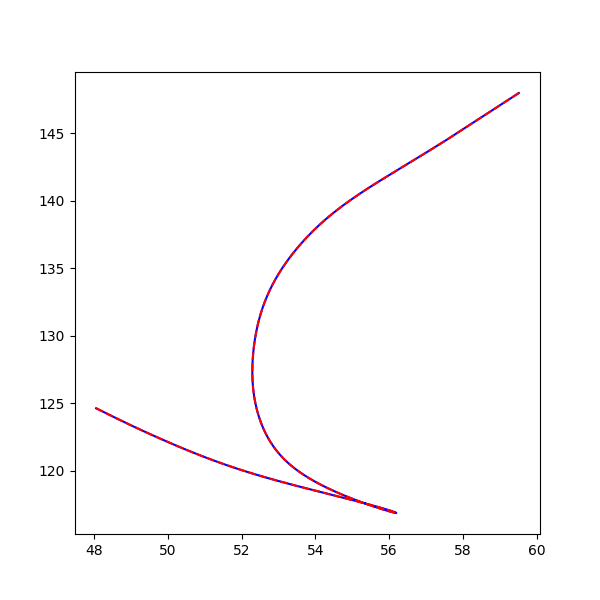

In [20]:
plt.plot(orig_atlas_geos[0][2],orig_atlas_geos[0][1],'b')
plt.plot(batchgeoz[0],batchgeoy[0],'r--')

In [33]:
for i in range(8):
  print(torchbatchgeox[i].shape)
  print(batchgeox[i].shape)
  xdiff = np.abs(torchbatchgeox[i].numpy()[::-1] - batchgeox[i])
  ydiff = np.abs(torchbatchgeoy[i].numpy()[::-1] - batchgeoy[i])
  zdiff = np.abs(torchbatchgeoz[i].numpy()[::-1] - batchgeoz[i])
  print(np.min(xdiff), np.max(xdiff),np.argmax(xdiff))
  print(np.min(ydiff), np.max(ydiff),np.argmax(ydiff))
  print(np.min(zdiff), np.max(zdiff),np.argmax(zdiff))

torch.Size([657])
(657,)
1.783954388656639e-07 0.00014952516661281834 0
1.1840938896057196e-08 0.00018052025950510142 4
5.327828489498643e-08 0.0001548752092546124 0
torch.Size([643])
(643,)
6.083908488108136e-09 0.00014330595579536975 0
2.2803756394296215e-07 0.00018479451856023843 2
3.3043264124898997e-08 4.0534588379159686e-05 1
torch.Size([618])
(618,)
3.3552039724327187e-07 0.00011221553609175317 617
1.3339587212612969e-09 3.3339651878350196e-05 23
6.964476995108271e-08 4.5493821865250084e-05 51
torch.Size([558])
(558,)
1.0086894519645284e-07 0.0001756205368224073 557
9.55948564751452e-09 9.152693939995515e-05 68
5.170193162484793e-10 5.78588037285499e-05 2
torch.Size([538])
(538,)
4.308049028622918e-09 3.5803782267862516e-05 514
3.96881176811803e-08 0.00010307616764748673 73
2.2387418141534e-08 5.8126662537461016e-05 5
torch.Size([441])
(441,)
4.270096098935028e-08 3.9627049240209544e-05 3
1.547687134006992e-08 5.683822709556807e-05 32
1.4963383421218168e-08 3.7918773088563285e-0

<IPython.core.display.Javascript object>


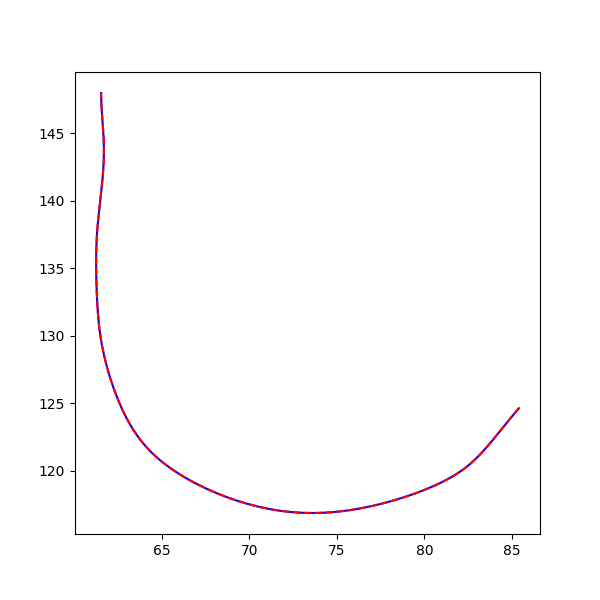

In [23]:
plt.plot(batchgeox[0],batchgeoy[0],'b')
plt.plot(torchbatchgeox[0].numpy(),torchbatchgeoy[0].numpy(),'r--')

<IPython.core.display.Javascript object>


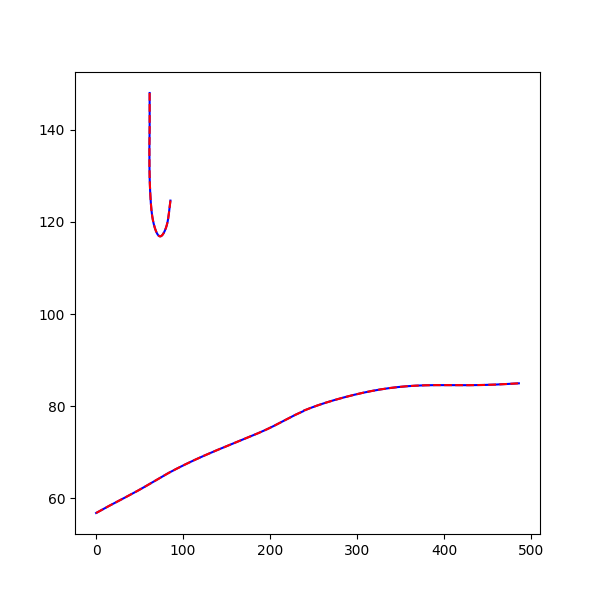

In [34]:
plt.figure()
plt.plot(batchgeox[7],'b')
plt.plot(torchbatchgeox[7].numpy()[::-1],'r--')

In [40]:
for i in range(8):
  print(gpubatchgeox[i].shape)
  print(batchgeox[i].shape)
  xdiff = np.abs(gpubatchgeox[i].cpu().numpy()[::-1] - batchgeox[i])
  ydiff = np.abs(gpubatchgeoy[i].cpu().numpy()[::-1] - batchgeoy[i])
  zdiff = np.abs(gpubatchgeoz[i].cpu().numpy()[::-1] - batchgeoz[i])
  print(np.min(xdiff), np.max(xdiff))
  print(np.min(ydiff), np.max(ydiff))
  print(np.min(zdiff), np.max(zdiff))

torch.Size([657])
(657,)
1.783954388656639e-07 0.00014952516661281834
1.1840938896057196e-08 0.00018052025950510142
5.327828489498643e-08 0.0001548752092546124
torch.Size([643])
(643,)
6.083908488108136e-09 0.00014330595579536975
2.2803756394296215e-07 0.00018479451856023843
3.3043264124898997e-08 4.0534588379159686e-05
torch.Size([618])
(618,)
3.3552039724327187e-07 0.00011221553609175317
1.3339587212612969e-09 3.3339651878350196e-05
6.964476995108271e-08 4.5493821865250084e-05
torch.Size([558])
(558,)
1.0086894519645284e-07 0.0001756205368224073
9.55948564751452e-09 9.152693939995515e-05
5.170193162484793e-10 5.78588037285499e-05
torch.Size([538])
(538,)
4.308049028622918e-09 3.5803782267862516e-05
3.96881176811803e-08 0.00010307616764748673
2.2387418141534e-08 5.8126662537461016e-05
torch.Size([441])
(441,)
4.270096098935028e-08 3.9627049240209544e-05
1.547687134006992e-08 5.683822709556807e-05
1.4963383421218168e-08 3.7918773088563285e-05
torch.Size([583])
(583,)
3.417263911842383e

<IPython.core.display.Javascript object>


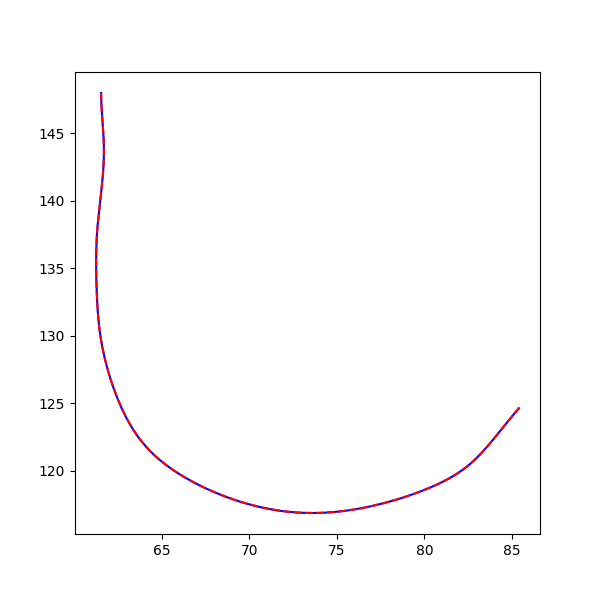

In [42]:
plt.figure()
plt.plot(batchgeox[0],batchgeoy[0],'b')
plt.plot(gpubatchgeox[0].cpu().numpy()[::-1],gpubatchgeoy[0].cpu().numpy()[::-1],'r--')

# Run larger tests

In [43]:
%%time
Gamma1, Gamma2, Gamma3 = geodesic.compute_gammas_3d(atlas_tens_4_path, atlas_mask)

Found 921 voxels where unable to take 1st derivative.
Found 5065 reduced accuracy 2nd derivative voxels.
CPU times: user 27.4 s, sys: 656 ms, total: 28.1 s
Wall time: 28.1 s


In [53]:
big_atlas_start_coords = []
xseedmin = 72
xseedmax = 79
yseedmin = 117
yseedmax = 124
zseedmin = 55
zseedmax = 60
for xx in np.linspace(xseedmin, xseedmax, num=18): # 5 orig
  for yy in np.linspace(yseedmin, yseedmax, num=18):
    for zz in np.linspace(zseedmin, zseedmax, num=18):
      if atlas_mask[math.floor(xx),math.floor(yy),math.floor(zz)] > 0.5:
        big_atlas_start_coords.append([xx,yy,zz])
print(len(big_atlas_start_coords))

5771


In [54]:
%%time

init_velocity = None

# Compute paths for atlas tensors
biggeox, biggeoy, biggeoz = geodesic.batch_geodesicpath_3d(atlas_tens_4_path, atlas_mask,\
                                  big_atlas_start_coords, init_velocity, \
                                  geo_delta_t, iter_num=geo_iters, both_directions=True)    

# CPU: 42.6 s for 120 geodesics at a time
# CPU: 5 min for 5771 geodesics.  expect ~ 31.3 minutes + 28 s for Gamma computation

Found 921 voxels where unable to take 1st derivative.
Found 5065 reduced accuracy 2nd derivative voxels.
CPU times: user 4min 59s, sys: 1.12 s, total: 5min
Wall time: 5min


In [46]:
%%time

init_velocity = None

# Compute paths for atlas tensors
biggeox, biggeoy, biggeoz = geodesic.batch_geodesicpath_3d(atlas_tens_4_path, atlas_mask,\
                                  big_atlas_start_coords, init_velocity, \
                                  geo_delta_t, iter_num=geo_iters, both_directions=True,
                                  Gamma1=Gamma1, Gamma2=Gamma2, Gamma3=Gamma3)    
# CPU: 13.4s for 120 geodesics Gamma precomputed

CPU times: user 13.4 s, sys: 20 ms, total: 13.4 s
Wall time: 13.4 s


In [56]:
%%time
batch_atlas_geos=[]

init_velocity = None

# Compute paths for atlas tensors
with torch.no_grad():  
  if do_GPU:
    biggpubatchgeox, biggpubatchgeoy, biggpubatchgeoz = geodesic.batch_geodesicpath_3d_torch( \
                                  torch.from_numpy(atlas_tens_4_path).cuda(), 
                                  torch.from_numpy(atlas_mask).cuda(),\
                                  torch.from_numpy(np.array(big_atlas_start_coords)).cuda(), init_velocity, \
                                  geo_delta_t, iter_num=geo_iters, both_directions=True, \
                                  Gamma1=torch.from_numpy(Gamma1).cuda(), \
                                  Gamma2=torch.from_numpy(Gamma2).cuda(), \
                                  Gamma3=torch.from_numpy(Gamma3).cuda())    
  else:
    bigtorchbatchgeox, bigtorchbatchgeoy, bigtorchbatchgeoz = geodesic.batch_geodesicpath_3d_torch( \
                                  torch.from_numpy(atlas_tens_4_path), 
                                  torch.from_numpy(atlas_mask),\
                                  torch.from_numpy(np.array(big_atlas_start_coords)), init_velocity, \
                                  geo_delta_t, iter_num=geo_iters, both_directions=True, \
                                  Gamma1=torch.from_numpy(Gamma1), \
                                  Gamma2=torch.from_numpy(Gamma2), \
                                  Gamma3=torch.from_numpy(Gamma3))    

# torch CPU: 10min 21s for 120 geodesics at a time, Gamma precomputed
# torch GPU: 3min 36s for 120 geodesics at a time, Gamma precomputed
# torch GPU: 48 min 2s for 5771 geodesics, Gamma precomputed, 173 min expected

CPU times: user 48min 2s, sys: 967 ms, total: 48min 2s
Wall time: 48min 2s


In [23]:
print(len(big_atlas_start_coords))

120


In [ ]:
full_atlas_start_coords = []
xseedmin = 0
xseedmax = atlas_mask.shape[0]-1
yseedmin = 0
yseedmax = atlas_mask.shape[1]-1
zseedmin = 0
zseedmax = atlas_mask.shape[2]-1
steps = [0,0.33,0.67]
for xx in np.linspace(xseedmin, xseedmax, num=atlas_mask.shape[0]):
  for yy in np.linspace(yseedmin, yseedmax, num=atlas_mask.shape[1]):
    for zz in np.linspace(zseedmin, zseedmax, num=atlas_mask.shape[2]):
      if atlas_mask[math.floor(xx),math.floor(yy),math.floor(zz)] > 0.5:
        for xoffs in steps:
          for yoffs in steps:
            for zoffs in steps:
              full_atlas_start_coords.append([xx+xoffs,yy+yoffs,zz+zoffs])
print(len(full_atlas_start_coords))

In [14]:
idx=np.where(np.zeros((3))>0)
print(idx)
print(len(idx))
print(idx[0].shape[0])
print(len(idx[0]))

(array([], dtype=int64),)
1
0
0
